<a href="https://colab.research.google.com/github/rsadaphule/jhu-dnn/blob/main/%5BGroup_13_Final_Submission%5D_9%F0%9F%8F%86%F0%9F%AA%90VenusMars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus vs Mars</font>](https://www.kaggle.com/competitions/24jul23jh-venus-vs-mars-jhu/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install tensorflow==2.7 >> log
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip install -U tfds-nightly tensorflow_addons tensorflow keras==2.12.0 >> log

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle >> log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 24jul23jh-venus-vs-mars-jhu # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 24jul23jh-venus-vs-mars-jhu
Using competition: 24jul23jh-venus-vs-mars-jhu
  teamId  teamName               submissionDate       score    
--------  ---------------------  -------------------  -------  
10744164  Kewei Cai              2023-08-06 18:29:02  0.98080  
10749697  Rebecca John           2023-08-06 19:36:27  0.97840  
10754684  Eric                   2023-08-06 19:06:38  0.97600  
10749298  Group 14               2023-08-05 22:08:05  0.97480  
10749198  Group 15               2023-08-06 04:02:02  0.97320  
10749876  Kristina Moralic       2023-08-06 01:13:22  0.96920  
10748229  Group 5                2023-08-06 02:13:32  0.96760  
10745375  Kain Place-Hildesheim  2023-08-06 18:05:22  0.96520  
10718368  Group 12               2023-08-06 19:26:35  0.96160  
10744517  Group 3                2023-08-06 17:19:58  0.96160  
10738803  Brian Yang             2023-08-06 04:54:10  0.96080  
1074290

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
!pip -q install -U tensorflow_addons plotly > log   # update tfa in case students need to use it
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.applications import resnet50, xception, mobilenet, mobilenet_v2, mobilenet_v3
from tensorflow.keras.utils import image_dataset_from_directory as idfd
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 4.95 s, sys: 496 ms, total: 5.44 s
Wall time: 19.6 s


Examples of images from female class

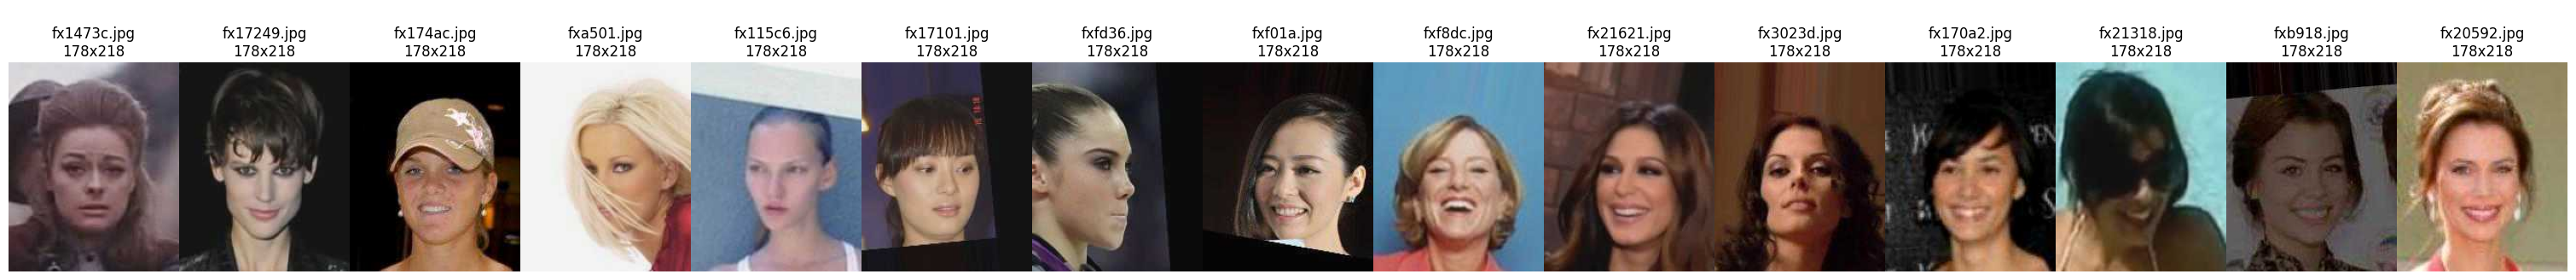

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

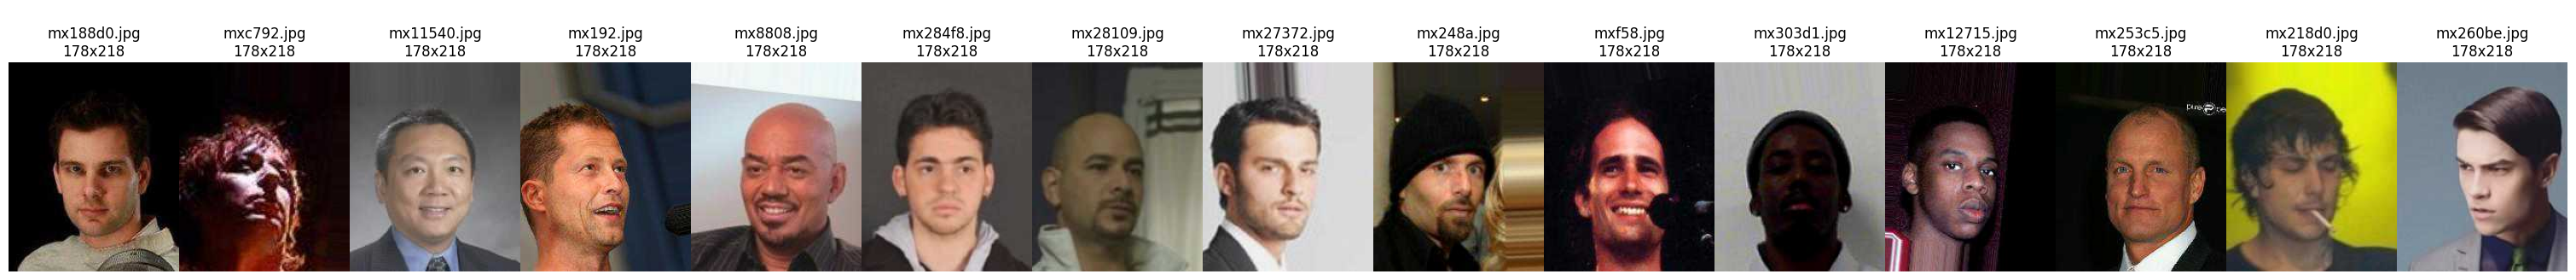

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

**NOTE: This Colab should be run on GPU**

**1. Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.**

We used data augmentation, namely applying random rotation and random brightness to the training images.

We also used the crop_to_aspect_ratio feature in image_dataset_from_directory to crop the image in a way that preserves the aspect ratio.

**2. Why did you choose these elements? (Perhaps something in EDA or prior experience lead you to these)**

We chose to apply data augmentation to help increase the diversity of the images. Doing so helps to prevent the model overfitting. We were able to validate that augmentation helped prevent overfitting by splitting the data into a training set vs a validation set. We saw that when augmentation was used, there was less overfitting: the difference in the loss and accuracy scores narrowed between the training and validation set. Whereas when augmentation was not used, we saw that performance on the training set was very good at the expense of performance on the validation set.

We also found that preserving the aspect ratio of the images and preventing the faces from being distorted helped improve the performance of the model when we came to evaluate it on the validation set.

**3. How do you evaluate the effectiveness of these elements?**

The effectiveness of these elements was gauged in terms of the cross entropy loss and accuracy scores locally on validation data. We plotted the learning curves to see how the learning progressed over each epoch. Large differences between the 2 allowed us to identify when the model was overfitting to the training set, especially when performance on the validation set started to drop over the number of epochs.

In addition to that, Kaggle’s public leaderboard scores helped us decide whether the preprocessing pipeline has a positive impact on the performance.

**4 What else have you tried that worked or didn't?**

We tried to use cropping instead of resizing the images to better preserve the original ratio. There is no convenient tool to auto crop the images and the dataset is too large to perform manual processing.

We tried additional data augmentation such as RandomFlip, RandomTranslation, etc. Using Tensorflow, these were very easy to implement, but there was no noticeable improvement when training the Xception or EfficientNetV2 models.

We tried converting to grayscale for Xception, Inceptionv3 and EfficientNetV2. Again, no noticeable gain, but it was an interesting task to determine how to convert the channel from 1 back to 3 as expected by the model. This was accomplished using grayscale_to_rgb in tensorflow.

We attempted using ImageDataGenerator to augment a set of images to train the model and predict new images. However this did not lead to any noticeable lift in performance.

![](https://drive.google.com/uc?export=view&id=16GTNzoh12P9jJ6v36dvDWCLYCFZ9sp_v)

## **Task 2.2**

**Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

**1. Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.**

After learning about pretrained models used for facial recognition such as facenet and VGGface through our research, and the fact that these are trained on millions of images of faces, this made us realize that we should leverage these types of models since they would be better at the task at hand where our dataset also consists of faces. Imagenet, the dataset that underpins many of the other models we tried (see below), consists of millions of images of objects, only a small fraction of which are faces. Therefore it makes sense that those models would have inferior performance on our task.

We attempted to implement both but were ultimately able to implement VGGface so ended up leveraging this model. After running a baseline model using VGGface, we were immediately able to achieve significantly higher performance compared to what we were previously getting which validated the hypothesis that models trained on faces fare better for our task.

Once we decided to pursue this model, we leverage many of the techniques we tried in our earlier exploration (see below) such as adding additional convolution/ dropout/ batchnorm layers, tuning the hyperparameters including the number of layers that were added, learning rate, learning schedule, optimiser, size of each layer, regularization, dropout factor and augmentation factor.

**2. How did these decisions guide you in modeling?**

We made decisions about what to include by assessing the impact on the validation set performance. The things we added let to better performance. While making these decisions about the model, we were careful not to overfit to the training set. So we did exhaustive testing of each change, noting down the validation performance so that we could make appropriate decisions about which values/ changes to adopt in our model. We also added in dropout to ensure that our model is more robust against overfitting.

**3. How do you evaluate the effectiveness of these elements?**

We evaluate the model performance by splitting the dataset into a training and a validation set. We would train the model on the training set and then evaluate it on the validation set. We assessed the model based on the accuracy score and the cross entropy loss. The hyperparameters that allowed us to achieve the best performance on these were selected for our final model. We also evaluated the model’s performance against the test set by evaluating the Kaggle leaderboard scores. This allowed us to make sure that the local performance correlates well with performance on the test set.

Another aspect that we considered as part of evaluation was the runtime constraint. We made sure that we were training a model that could be run within the 5 mins limit. This acted as a constraint on the size of the model as well as the number of epochs we chose to run it over.

**4. What else have you tried that worked or didn't?**

We tried out many of the different pretrained models within Keras including Xception, Inceptionv3, EfficientNetV2, VGG16, ResNet50V2, ResNet101V2, MobileNetV2 and ConvNeXtTiny of several different sizes [6]. We first ran these with a baseline set of hyperparameters in order to determine which one performed best on the validation set. We eliminated the ones that did not perform well. We also eliminated ones that took a long time to run, which would have limited the number of epochs we could ultimately run it for.

Based on these experiments, we narrowed it down to Xception and ResNet50V2. Then we worked on building the best architecture on top of these baseline models. This included unfreezing the top layers and adding additional convolution/ dropout/ batchnorm layers. We also worked on tuning the hyperparameters including the number of layers that were added, learning rate, learning schedule, optimiser, size of each layer, regularization, dropout factor and augmentation factor.

Even after an exhaustive search of this search space, the best validation accuracy we obtained was 0.945 on our local validation set. Submitting to Kaggle, we got a score of 0.92 which made us rethink our approach.

### Model

In [ ]:
## FYI: THIS ASSUMES YOU HAVE PYTHON3.10 INSTALLED AND DOWNLOADS VGGFACE TO THE CORRESPONDING LOCAL DIRECTORY
!pip install keras_vggface
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from keras_vggface.vggface import VGGFace

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-tnvfnxxi
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-tnvfnxxi
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done


20951

In [ ]:
DIMENSION = 299
BS, image_size = 32, (DIMENSION, DIMENSION)  # batch size; image dimensions required by pretrained model

# Define datasets
all_data = idfd(
    tDIR,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=BS,
    image_size=image_size,
    shuffle=True,
    crop_to_aspect_ratio=True,
    seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset

sDS = idfd(
    sDIR,
    labels=None,
    label_mode='binary',
    subset=None,
    validation_split=None,
    class_names=None,
    color_mode='rgb',
    batch_size=BS,
    image_size=image_size,
    shuffle=False,
    crop_to_aspect_ratio=True,
    seed=0)           # don't prefetch this testing dataset

Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 1 classes.


In [ ]:
# Perform data augmentation
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomRotation((-0.01,0.01), seed = 42),
  keras.layers.RandomBrightness((-0.1,0.1), seed = 42)
])

In [ ]:
%%time
from tensorflow.keras.layers import BatchNormalization

tf.random.set_seed(0) # always seed your experiments
Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

LEARNING_RATE = 0.1
EPOCHS = 6

# Load the Pre-Trained Base Model
vggface_resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(DIMENSION,DIMENSION,3))
vggface_resnet_base.trainable = False

inputs = tf.keras.Input(shape=(DIMENSION, DIMENSION, 3))
x = data_augmentation(inputs)

pm = vggface_resnet_base(x, training=False)

# Add additional layers to the top of the model
x0 = keras.layers.BatchNormalization()(pm)
x1 = keras.layers.Conv2D(2048, 1, activation='relu', padding='same')(x0) #, kernel_regularizer=keras.regularizers.l2(0.00001)
x2 = keras.layers.Dropout(0.2)(x1)
x3 = keras.layers.BatchNormalization()(x2)

avg = GlobalAveragePooling2D(data_format='channels_last')(x3)
output = Dense(1, activation="sigmoid", kernel_initializer="he_normal")(avg)
pm1 = keras.Model(inputs=inputs, outputs=output)

lrs = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE, decay_steps=500, decay_rate=0.5)

pm1.compile(
  loss="binary_crossentropy",
  optimizer=keras.optimizers.SGD(learning_rate=lrs, momentum=0.9),
  metrics=["accuracy"])

pm1.summary()

hist = pm1.fit(
  all_data,
  epochs=EPOCHS)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 2048)        4196352   
                                                                 
 dropout (Dropout)           (None, 1, 1, 2048)        0     

In [ ]:
vIDs = [f.split('/')[1].split('.')[0] for f in sDS.file_paths]   # parse image IDs from file names
pY = pd.DataFrame(pm1.predict(sDS), index=vIDs, columns=['y'])   # predicted targets
ToCSV((pY>0.5)*1, 'aug_6_vggface_v5')

157/157 [==============================] - 25s 148ms/step


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

[1] Géron, A. (2019). Hands-on machine learning with Scikit-learn, Keras, and Tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media.

[2] Machine Learning Mastery, ​​How to Perform Face Recognition With VGGFace2 in Keras, https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

[2] Width AI, How to Implement TensorFlow Facial Recognition From Scratch, https://www.width.ai/post/tensorflow-facial-recognition

[3] Big Cats Classification | Xception | Acc : 100%, https://www.kaggle.com/code/utkarshsaxenadn/big-cats-classification-xception-acc-100#Backbone-Analysis-%F0%9F%AA%81%F0%9F%AA%AC

[5] Ryu, H. J., Adam, H., & Mitchell, M. (2018). InclusiveFaceNet: Improving Face Attribute Detection with Race and Gender Diversity. arXiv:1712.00193 [cs.CV].

[6] Chollet, F. (2015). https://keras.io/api/applications/

[7] Team, K. (n.d.). Keras Documentation: Inceptionv3. Keras. https://keras.io/api/applications/inceptionv3/

[8] Keras, Transfer learning and fine-tuning, https://www.tensorflow.org/tutorials/images/transfer_learning#evaluation_and_prediction

[9] Neptune AI, Transfer Learning Guide: A Practical Tutorial With Examples for Images and Text in Keras, https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras


<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 288 sec


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.